# Filter posts on the reddit related to the ***POTUS2016***

python=3.7

(time：October 1, 2016 to February 28 2017)

In [1]:
import pandas as pd
from joblib import Parallel, delayed
from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# show all columns in the DataFrame
pd.set_option('display.max_columns', None)
# fully display the content in displayed table cells
pd.set_option('display.max_colwidth', None)

name_suffix = "[debunking=keywords][lang=en][topic=POTUS2016][platform=Reddit]"

## Use keywords to select comments related to ***COVID-19***

In [ ]:
import os
import re
from datetime import datetime
import pandas as pd
from multiprocessing import Pool

# keywords
keywords = ["MAGA", "MakeAmericaGreatAgain", "Trump", "AmericaFirst", "Make America Great Again", 
             "Hillary", "Clinton", "ImWithHer", "OHHillYes", 
             "election2016", "elections2016", "debates2016"]

# file path
source_path = "/mnt/data/reddit/reddit/RC/"
target_path = "data/csv_filtered/"

# set time range
start_date = datetime.strptime("2016-10", "%Y-%m")
end_date = datetime.strptime("2017-02", "%Y-%m")

# settings for result filename
label = 'en+POTUS2016'
content = 'comment'

# format of source filename
date_str_pattern = r'RC_(.*?)\.zst\.csv'

# other settings
chunksize = 1e6
proc_num = 6

def process_file(source_name):
    # check file name
    mtch = re.search(date_str_pattern, source_name)
    if mtch:
        # get date from file name
        date_str = mtch.group(1)
        file_date = datetime.strptime(date_str, '%Y-%m')
        
        # check if the date in time range. if yes, process the file.
        if start_date <= file_date <= end_date:
            print(f"processing {source_name} ... ...\n", end='')
            target_name = f"{content}[{label}][{date_str}].csv"

            # check if the target file already exists
            if os.path.exists(target_path + target_name):
                print(f"{target_name} already exists.\n", end='')
                return

            try:
                for chunk in pd.read_csv(source_path + source_name, chunksize=chunksize, engine='python'):
                    df = chunk[chunk['body'].astype(str).str.contains('|'.join(keywords), case=False)]
                    df.to_csv(target_path + target_name, mode='a', index=False)
                print(f"{source_name} processed.\n", end='')
            except Exception as e:
                print(f"failed processing {source_name}.\n{e}\n", end='')

# get a list of files
files = os.listdir(source_path)

# create a pool of workers
with Pool(processes=proc_num) as pool:
    pool.map(process_file, files)

print("Done.")

In [2]:
import os

folder_path = 'data/csv_filtered'
all_data = pd.DataFrame()

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path) and filename.endswith('.csv'):
        print(file_path)
        df = pd.read_csv(file_path, engine='python')
        all_data = all_data.append(df, ignore_index=True)

all_data.info()

data/csv_filtered/comment[en+POTUS2016][2016-11].csv
data/csv_filtered/comment[en+POTUS2016][2017-01].csv
data/csv_filtered/comment[en+POTUS2016][2016-12].csv
data/csv_filtered/comment[en+POTUS2016][2017-02].csv
data/csv_filtered/comment[en+POTUS2016][2016-10].csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7567018 entries, 0 to 7567017
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   created_utc   object
 1   author        object
 2   subreddit     object
 3   body          object
 4   parent_id     object
 5   subreddit_id  object
 6   id            object
dtypes: object(7)
memory usage: 404.1+ MB


In [9]:
# considering four possibilities
df=all_data.query("author !='[deleted]' & body!='[deleted]'")
df=df.query("author !='[removed]' & body!='[deleted]'")
df=df.query("author !='[removed]' & body!='[removed]'")
df=df.query("author !='[deleted]' & body!='[removed]'")
len(df)

7450007

In [8]:
invalid_signs = {'[deleted]', '[removed]'}
df = all_data[ ~ (all_data['author'].isin(invalid_signs) | all_data['body'].isin(invalid_signs))]
len(df)

7450007

In [4]:
# language detection
from langdetect import detect
def detectlang(x):
    try:
        return (detect(x))
    except:
        return ''

from pandarallel import pandarallel
# Initialization
pandarallel.initialize(progress_bar=True, nb_workers=50)
# Parallel apply
df['lang'] = df['body'].parallel_apply(detectlang).tolist()

df.to_csv(f'data/comments{name_suffix}.csv',index=None)

INFO: Pandarallel will run on 50 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
# check the number of language types
unique_lang_count = df['lang'].value_counts()
unique_lang_count.head(10)

en    7226226
        27910
de      25632
vi      13542
it      13163
fr      12742
ro      11773
tl      10927
da      10293
id       9815
Name: lang, dtype: int64

## Based on previous selection, use debunking keywords for filtering

In [2]:
df = pd.read_csv(f"data/comments{name_suffix}.csv")

# English debunking keywords
debunk_keywords_en = [
    'fact check', 'fact-checking', 'fact checkers', 'fake news', 'misinformation', 'disinformation', 
    'debunkers', 'debunker', 'debunking', 'debunk'
]

# get more debunking key words
debunk_site = pd.read_csv("data/(Merge_ver3)debunking_fact-checking_sites.csv")
debunk_site = debunk_site.dropna(subset=['domain'])
debunk_site_domain = debunk_site['domain'].to_list()
debunk_site_name = debunk_site['name'].to_list()

df_debunk_en = df[
    (df['lang'] == 'en') &  # '&' has higher priority than '=='
    df['body'].astype(str).str.contains('|'.join(debunk_keywords_en + debunk_site_domain + debunk_site_name), case=False)
]

df_debunk_en.sort_values('created_utc', inplace=True)
df_debunk_en.to_csv(f"data/debunking_comments{name_suffix}.csv", index=False)
df_debunk_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157917 entries, 5922273 to 5922156
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   created_utc   157917 non-null  object
 1   author        157917 non-null  object
 2   subreddit     157917 non-null  object
 3   body          157917 non-null  object
 4   parent_id     157915 non-null  object
 5   subreddit_id  157915 non-null  object
 6   id            157915 non-null  object
 7   lang          157917 non-null  object
dtypes: object(8)
memory usage: 10.8+ MB


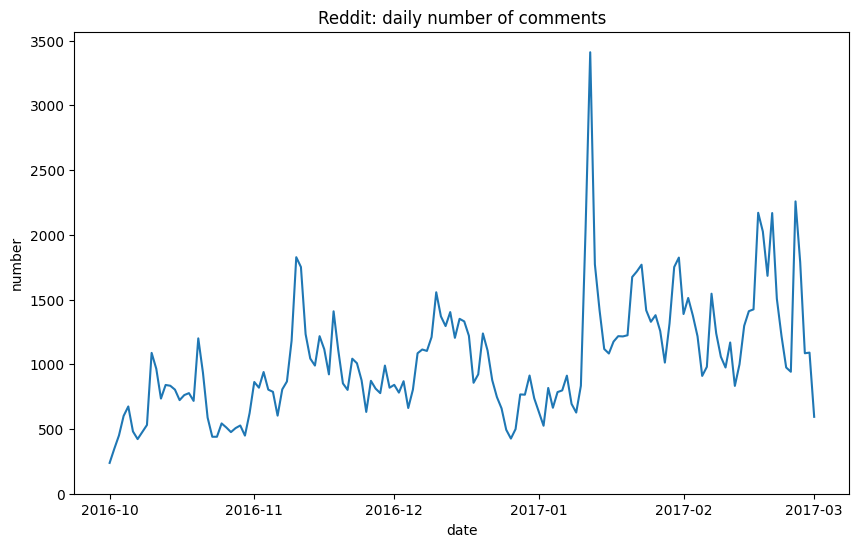

In [3]:
# Generate a statistical graph of the number of posts changing by day.
df = pd.read_csv(f"data/debunking_comments{name_suffix}.csv")

df['created_utc'] = pd.to_datetime(df['created_utc'])
df['date'] = df['created_utc'].dt.date 

date_range = pd.date_range(start=df['date'].min(), end=df['date'].max())
daily_counts = df.groupby('date').size()  
daily_counts = daily_counts.reindex(date_range, fill_value=0)

plt.figure(figsize=(10, 6))

sns.lineplot(data=daily_counts)

plt.title('Reddit: daily number of comments')
plt.ylim((0,None))
plt.xlabel('date')
plt.ylabel('number')
plt.show()